<a href="https://colab.research.google.com/github/KauaHenSilva/python_background_subtraction/blob/main/temporal_median_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Pacotes externos

In [1]:
import os

In [2]:
if os.path.exists('python_download_file_drive'):
  !cd python_download_file_drive && git pull
else:
  !git clone https://github.com/KauaHenSilva/python_download_file_drive

Cloning into 'python_download_file_drive'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 6.51 KiB | 6.51 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
%pip install --upgrade --quiet -r python_download_file_drive/requirements.txt

## baixando arquivos requeridos

In [4]:
%%capture
!python "python_download_file_drive/main.py" "https://drive.google.com/drive/folders/13LvSXf8YsCxARsMxiRX8RZBRUGzW7RaY?usp=drive_link" arq --folder

## Função de exibição de video

In [5]:
%pip install --upgrade --quiet ffmpeg-python
import ffmpeg
import base64
import io
from IPython.display import HTML
import tempfile

In [6]:
import ffmpeg
import io
import base64
import tempfile
from IPython.core.display import HTML

def compress_video(input_file, output_file, resolution=(640, 360), bitrate="500k", tempo_max=None):
    if tempo_max:
        input_vid = ffmpeg.input(input_file, t=tempo_max)
    else:
        input_vid = ffmpeg.input(input_file)
    input_vid.output(output_file, vf=f'scale={resolution[0]}:{resolution[1]}', video_bitrate=bitrate).run(overwrite_output=True, quiet=True)

def show_video(name_file, otimized=False, tempo_max=None):
    if otimized:
        with tempfile.NamedTemporaryFile(suffix=".mp4", delete=False) as temp_video:
            compressed_file = temp_video.name
            compress_video(name_file, compressed_file, tempo_max=tempo_max)
        name_file = compressed_file

    video = io.open(name_file, 'r+b').read()
    encoded = base64.b64encode(video).decode('ascii')

    return f'''
    <video width="320" height="180" controls>
        <source src="data:video/mp4;base64,{encoded}" type="video/mp4">
    </video>'''

def show_videos_side_by_side(video1, video2, otimized=False, tempo_max=None):
    video_html1 = show_video(video1, otimized, tempo_max)
    video_html2 = show_video(video2, otimized, tempo_max)

    return HTML(f'''
    <div style="display: flex; gap: 10px;">
        {video_html1}
        {video_html2}
    </div>
    ''')

# Mediana temporal

In [7]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [8]:
path_video = "/content/arq/Curso_Subtraction/videos/Cars.mp4" #@param {type:"string"}

In [9]:
vidio = cv2.VideoCapture(path_video)
ok, frame = vidio.read()
if not ok:
  raise Exception("Não foi possivei ler o arquivo!")

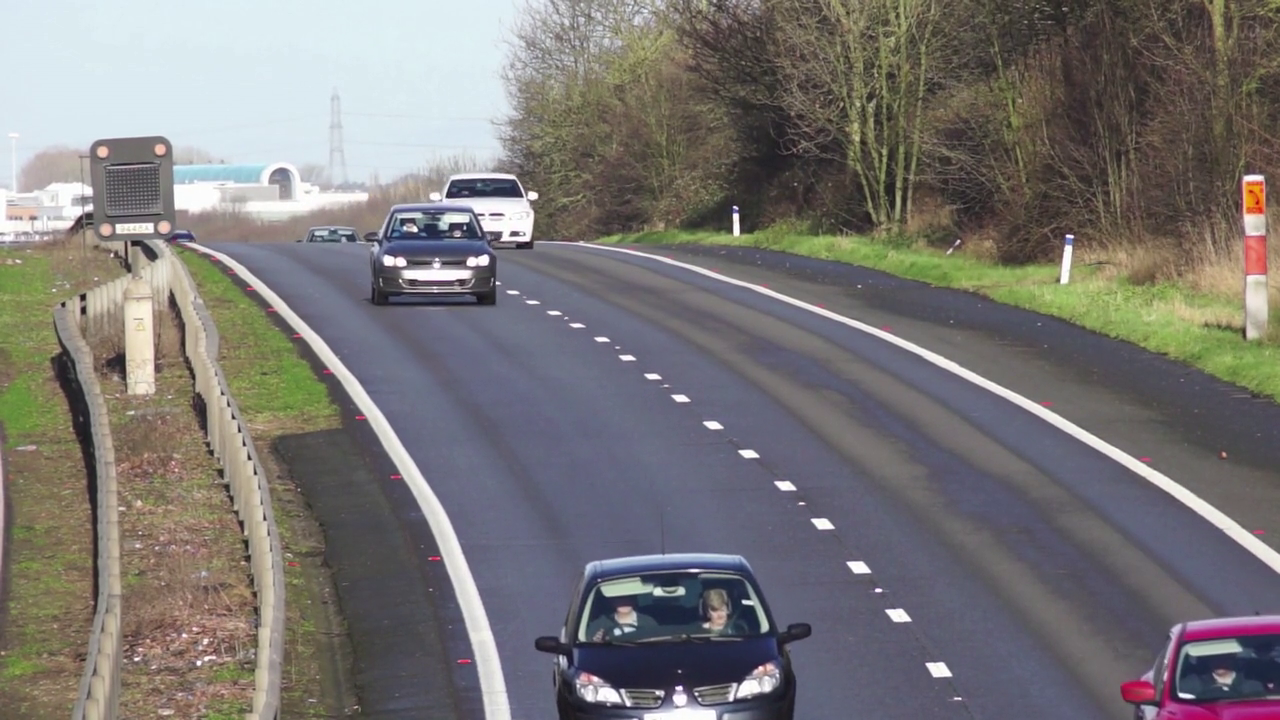

In [10]:
frames_ids = vidio.get(cv2.CAP_PROP_FRAME_COUNT) * np.random.uniform(size=40)
vidio.set(cv2.CAP_PROP_POS_FRAMES, frames_ids[0])
ok, frame = vidio.read()
if not ok:
  raise Exception("Não foi possivei ler o arquivo!")
cv2_imshow(frame)

In [11]:
frames = []
for fid in frames_ids:
  vidio.set(cv2.CAP_PROP_POS_FRAMES, fid)
  ok, frame = vidio.read()
  if not ok:
    raise Exception("Não foi possivei ler o arquivo!")
  frames.append(frame)
np.asarray(frames).shape

(40, 720, 1280, 3)

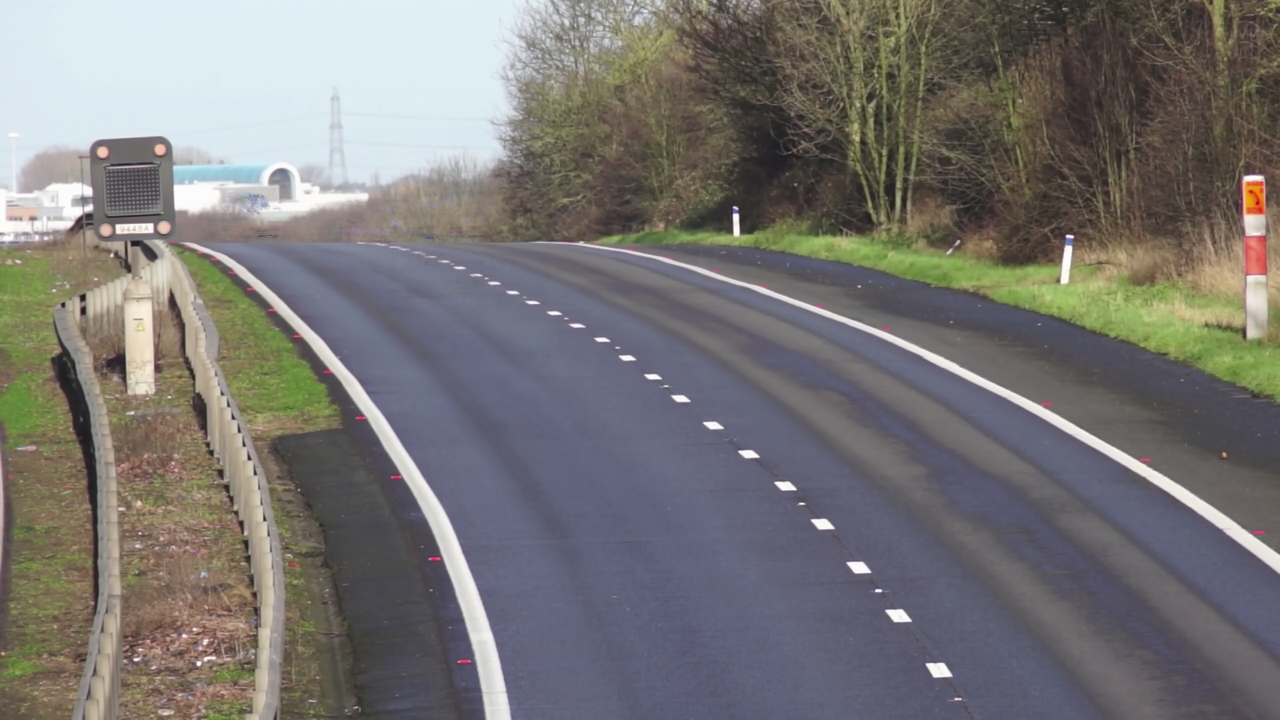

In [12]:
median_frame = np.median(frames, axis=0).astype(dtype=np.uint8)
cv2_imshow(median_frame)

In [13]:
vidio = cv2.VideoCapture(path_video)
ok, frame = vidio.read()
forcc = cv2.VideoWriter_fourcc(*'MP4V')
out1 = cv2.VideoWriter("1.mp4", forcc, 24, (frame.shape[1], frame.shape[0]))
out2 = cv2.VideoWriter("2.mp4", forcc, 24, (frame.shape[1], frame.shape[0]))

In [14]:
grey_median_frame = cv2.cvtColor(median_frame, cv2.COLOR_BGR2GRAY)

while True:
  ok, frame = vidio.read()
  if not ok:
    break
  grey_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  dframe = cv2.absdiff(grey_median_frame, grey_frame)
  th, dframe = cv2.threshold(dframe, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  dframe = cv2.cvtColor(dframe, cv2.COLOR_GRAY2BGR)

  out1.write(frame)
  out2.write(dframe)

out1.release()
out2.release()
vidio.release()

# Resultados (Utilize o colab ou vscode para visualizar)

In [15]:
show_videos_side_by_side('1.mp4', '2.mp4', True, 10)